In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 

In [2]:
# pulled in dataframe
df = pd.read_csv('../../src/data/syriatel_customer_churn.csv')


In [3]:
# dropped area code and phone number. still looking into if area code should be included
df = df.drop(['area code', 'phone number'], axis = 1)

In [4]:
X = df.drop('churn', axis=1)
y = df['churn']

In [8]:
# Saving dataframes to src/data folder to be able to use in any notebook. 
#X.to_csv('../../src/data/X_dataframe.csv')
#y.to_csv('../../src/data/y_dataframe.csv')

In [5]:
# train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
# Our first model should have accuracy above 86 percent.
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
y_hat_dummy = dummy_model.predict(X_test)

In [7]:
y_test.value_counts()

False    709
True     125
Name: churn, dtype: int64

In [8]:
print(dummy_model.score(X_test, y_test))
print(confusion_matrix(y_test, y_hat_dummy))
print(classification_report(y_test, y_hat_dummy))

0.8501199040767387
[[709   0]
 [125   0]]
              precision    recall  f1-score   support

       False       0.85      1.00      0.92       709
        True       0.00      0.00      0.00       125

    accuracy                           0.85       834
   macro avg       0.43      0.50      0.46       834
weighted avg       0.72      0.85      0.78       834



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
def One_hot(X):
    '''
    Returns data frame of X_train and X_test of catagorical columns one 
    hot encoded merged with continous columns. 
    Catagorical anything that is an object and continous is not object
    '''
    X_num = X.select_dtypes(exclude='object') # numerical cols
    X_cat = X.select_dtypes(include='object') # categorical cols
    
    ohe = OneHotEncoder(drop='first', sparse=False)
    ohe.fit(X_cat)

    X_catagory = pd.DataFrame(ohe.transform(X_cat),
                                      columns=ohe.get_feature_names(X_cat.columns),
                                        index=X.index)
    X_ohe = X_num.merge(X_catagory,
                           left_index=True,
                          right_index=True)
    


    return X_ohe, X_catagory

In [10]:
X_train_ohe, X_train_catagory = One_hot(X_train)

In [11]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train_ohe), index= X_train_ohe.index, columns= X_train_ohe.columns)

# Smote

In [12]:
# for reproducibility purposes
sm = SMOTE(random_state=42)


# SMOTE number of neighbors


X_resample, y_resample = sm.fit_resample(X_train_ss, y_train)

In [13]:
y_resample.value_counts()

True     2141
False    2141
Name: churn, dtype: int64

In [14]:
X_test_ohe, X_test_catagory = One_hot(X_test)

In [15]:
ss = StandardScaler()
ss.fit(X_train_ohe)
X_test_ss = pd.DataFrame(ss.transform(X_test_ohe), index= X_test_ohe.index, columns= X_test_ohe.columns)

# Log first model

In [16]:
log1 = LogisticRegression(random_state=42)

log1.fit(X_resample, y_resample)
y_hat_log1 = log1.predict(X_test_ss)


print(log1.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_log1))
print(classification_report(y_test, y_hat_log1))

0.7841726618705036
[[557 152]
 [ 28  97]]
              precision    recall  f1-score   support

       False       0.95      0.79      0.86       709
        True       0.39      0.78      0.52       125

    accuracy                           0.78       834
   macro avg       0.67      0.78      0.69       834
weighted avg       0.87      0.78      0.81       834



In [17]:
grid_log = {
    'C': np.logspace(-3, 3, 20),
}

gs_log = GridSearchCV(estimator=LogisticRegression(), param_grid=grid_log, cv=3)

In [18]:
gs_log.fit(X_resample, y_resample)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])})

In [19]:
gs_log.best_params_

{'C': 233.57214690901213}

In [20]:
gs_log.best_score_

0.7919217675390642

In [21]:
log2 = LogisticRegression(C = 233.57214690901213, random_state=42)
log2.fit(X_resample, y_resample)
y_hat_log2 = log2.predict(X_test_ss)

print(log1.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_log2))
print(classification_report(y_test, y_hat_log2))

0.7841726618705036
[[556 153]
 [ 28  97]]
              precision    recall  f1-score   support

       False       0.95      0.78      0.86       709
        True       0.39      0.78      0.52       125

    accuracy                           0.78       834
   macro avg       0.67      0.78      0.69       834
weighted avg       0.87      0.78      0.81       834



Did about the same when setting a C value. 

# Random Forest 1st model

In [22]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_resample, y_resample)
y_hat_forest = forest.predict(X_test_ss)

print(forest.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_forest))
print(classification_report(y_test, y_hat_forest))

0.9244604316546763
[[678  31]
 [ 32  93]]
              precision    recall  f1-score   support

       False       0.95      0.96      0.96       709
        True       0.75      0.74      0.75       125

    accuracy                           0.92       834
   macro avg       0.85      0.85      0.85       834
weighted avg       0.92      0.92      0.92       834



# Grid with Random forest

In [23]:
grid_forest = {
    'max_features': ['sqrt', 'log2', 0.5],
    'criterion': ['gini', 'entropy'],
    'n_estimators' : [50, 100, 200]
}

In [24]:
gs_for = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_forest, cv=3)

In [25]:
gs_for.fit(X_resample, y_resample)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2', 0.5],
                         'n_estimators': [50, 100, 200]})

In [26]:
gs_for.best_params_

{'criterion': 'gini', 'max_features': 0.5, 'n_estimators': 200}

In [27]:
gs_for.best_score_

0.945355413831031

In [29]:
forest2 = RandomForestClassifier(max_features=.5, random_state=42)
forest2.fit(X_resample, y_resample)
y_hat_forest2 = forest2.predict(X_test_ss)

print(cross_val_score(estimator=RandomForestClassifier(max_features=.5, random_state=42), X= X_resample, y = y_resample, cv = 3).mean())
print(forest2.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_forest2))
print(classification_report(y_test, y_hat_forest2))

0.9402169183487458
0.947242206235012
[[689  20]
 [ 24 101]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       709
        True       0.83      0.81      0.82       125

    accuracy                           0.95       834
   macro avg       0.90      0.89      0.90       834
weighted avg       0.95      0.95      0.95       834



# KNN with Grid

In [30]:
grid_knn = {
    'n_neighbors': list(range(3,31,2)),
    'p' : [1,2]
}

In [31]:
gs_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid_knn, cv=5)

In [32]:
gs_knn.fit(X_resample, y_resample)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29],
                         'p': [1, 2]})

In [33]:
gs_knn.best_params_

{'n_neighbors': 3, 'p': 1}

In [34]:
knn = KNeighborsClassifier(n_neighbors=3, p=1)
knn.fit(X_resample, y_resample)
y_hat_knn = knn.predict(X_test_ss)

print(forest2.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_knn))
print(classification_report(y_test, y_hat_knn))

0.947242206235012
[[554 155]
 [ 67  58]]
              precision    recall  f1-score   support

       False       0.89      0.78      0.83       709
        True       0.27      0.46      0.34       125

    accuracy                           0.73       834
   macro avg       0.58      0.62      0.59       834
weighted avg       0.80      0.73      0.76       834



# SVM model

In [35]:
svm = SVC(random_state=42)
svm.fit(X_resample, y_resample)
svm.score(X_test_ss, y_test)

0.8237410071942446

In [37]:
y_hat_svm = svm.predict(X_test_ss)

print(svm.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_svm))
print(classification_report(y_test, y_hat_svm))

0.8237410071942446
[[614  95]
 [ 52  73]]
              precision    recall  f1-score   support

       False       0.92      0.87      0.89       709
        True       0.43      0.58      0.50       125

    accuracy                           0.82       834
   macro avg       0.68      0.73      0.70       834
weighted avg       0.85      0.82      0.83       834



# Adaboost model

In [39]:
gb = XGBClassifier(random_state=42)

gb.fit(X_resample, y_resample)

y_hat_gb = gb.predict(X_test_ss)

print(gb.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_gb))
print(classification_report(y_test, y_hat_gb))

0.9508393285371702
[[700   9]
 [ 32  93]]
              precision    recall  f1-score   support

       False       0.96      0.99      0.97       709
        True       0.91      0.74      0.82       125

    accuracy                           0.95       834
   macro avg       0.93      0.87      0.90       834
weighted avg       0.95      0.95      0.95       834



# Stacking

In [42]:
estimators = [
    ('svm', svm),
    ('knn', knn),
    ('forest', forest2)
]

sr = StackingClassifier(estimators)

In [43]:
sr.fit(X_resample, y_resample)

StackingClassifier(estimators=[('svm', SVC(random_state=42)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=3, p=1)),
                               ('forest',
                                RandomForestClassifier(max_features=0.5,
                                                       random_state=42))])

In [44]:
y_hat_sr = sr.predict(X_test_ss)

print(sr.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_sr))
print(classification_report(y_test, y_hat_sr))

0.894484412470024
[[686  23]
 [ 65  60]]
              precision    recall  f1-score   support

       False       0.91      0.97      0.94       709
        True       0.72      0.48      0.58       125

    accuracy                           0.89       834
   macro avg       0.82      0.72      0.76       834
weighted avg       0.88      0.89      0.89       834



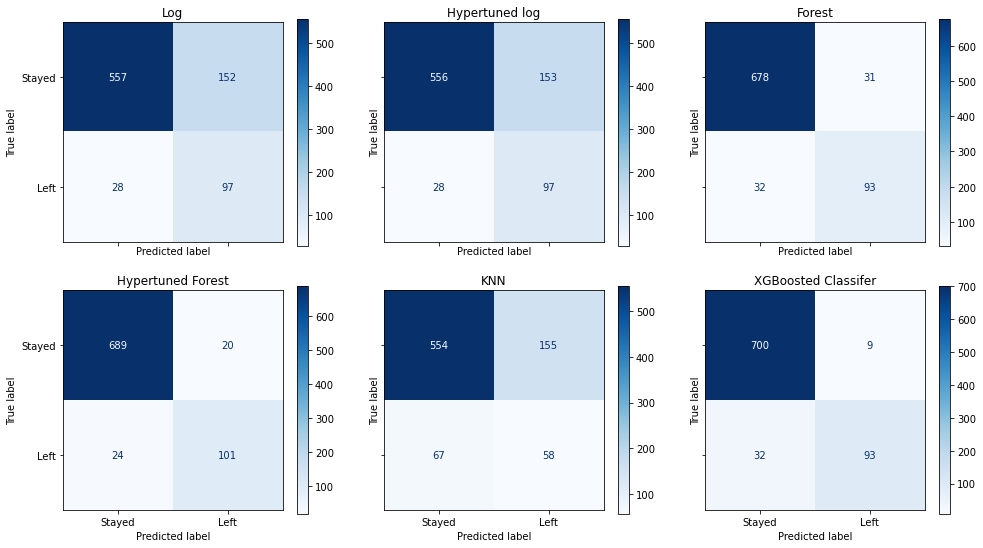

In [133]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize =(14,8), sharex = True, sharey = True)
fig.tight_layout(pad=3.0)


counter = 0

model = [log1, log2, forest, forest2, knn, gb]
name = ['Log', 'Hypertuned log', 'Forest', 'Hypertuned Forest', 'KNN', 'XGBoosted Classifer']

for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        plot_confusion_matrix(model[counter], X_test_ss, y_test, ax = axs[row,col], cmap="Blues", display_labels= ('Stayed','Left'))
        if row in [0]:
            axs[row, col].tick_params(labelbottom=False)
        # remove the y-axis tick marks from the second and third columns of subplots
        if col in [1,2]:
            axs[row, col].tick_params(labelleft=False)     
        axs[row, col].set_title(name[counter],  
                                fontsize=12, 
                                fontweight=0)
    
        counter += 1
        
plt.savefig('../report/figures/Early_Models', dpi = 300)

In [44]:
def plot_feature_importances(model):
    n_features = X_resample.shape[1]
    plt.figure(figsize=(8,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_resample.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.savefig(f'../report/figures/{str(model)}Feature_importance.png',dpi=300, bbox_inches='tight') 

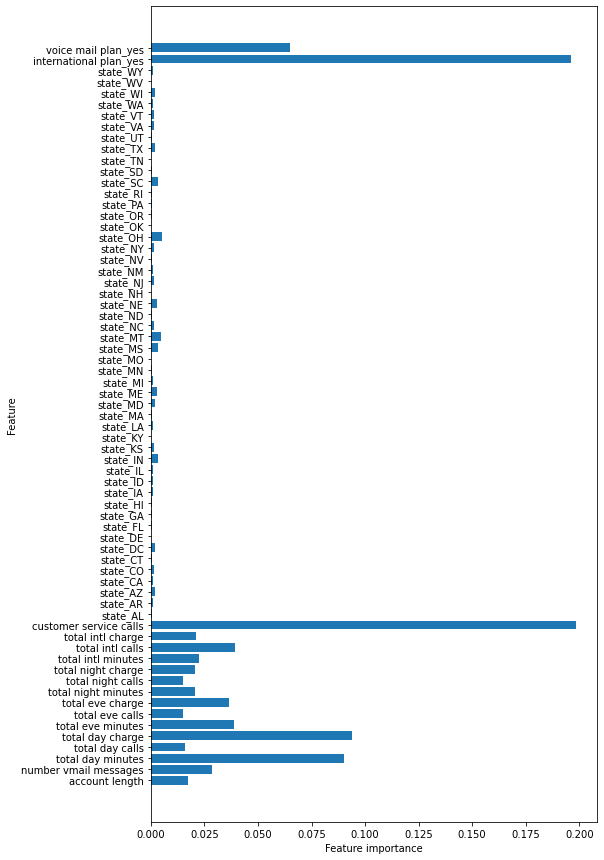

In [51]:
plot_feature_importances(forest_final)

Looks like customer service calls, international plan, voice mail plan, total days charge, total day minutes are the biggest influence on this model. 

# International Plan Churn Rate

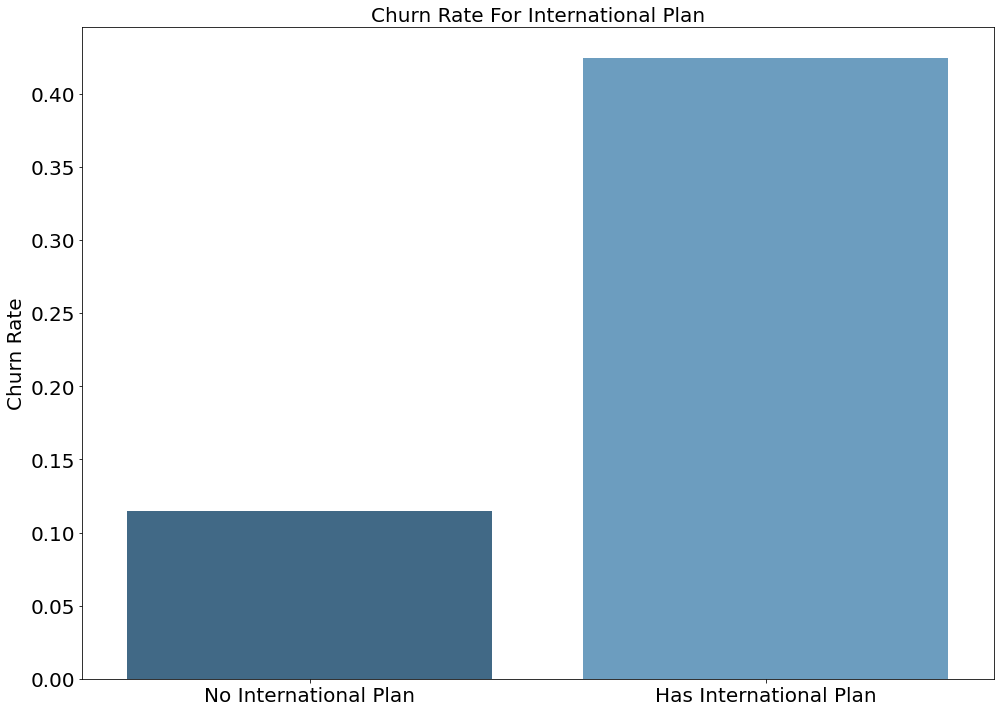

In [141]:
churn_rate_int = df.groupby(['international plan'])['churn'].mean()

fig, ax = plt.subplots(figsize =(14,10))
sns.barplot(x = churn_rate_int.index, y = churn_rate_int.values, ax = ax, palette = "Blues_d")

plt.title('Churn Rate For International Plan', fontsize = 20)
plt.xlabel('')
plt.ylabel('Churn Rate', fontsize = 20)

ax.tick_params(labelsize = 20)
ax.set_xticklabels(['No International Plan', 'Has International Plan'])
plt.tight_layout()
plt.savefig('../report/figures/Internationalplan.png',dpi=300, bbox_inches='tight') 

# Customer Service calls Churn rate

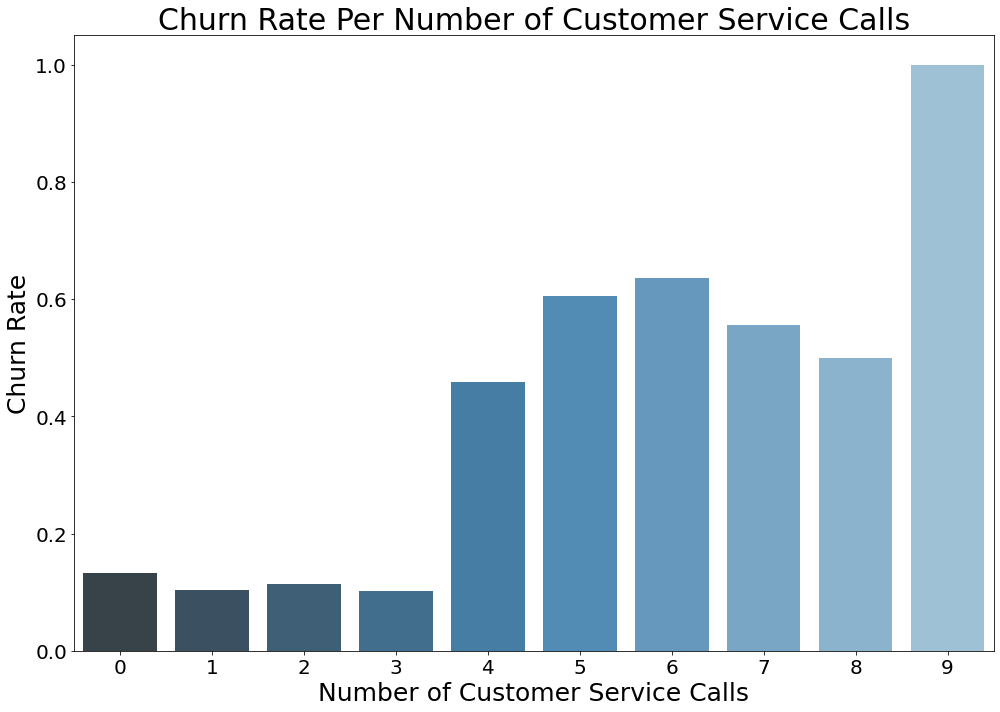

In [135]:
churn_rate_cust_service = df.groupby(['customer service calls'])['churn'].mean()

fig, ax = plt.subplots(figsize =(14,10))
sns.barplot(x = churn_rate_cust_service.index, y = churn_rate_cust_service.values, ax = ax, palette = "Blues_d")

plt.title('Churn Rate Per Number of Customer Service Calls', fontsize = 30)
plt.xlabel('Number of Customer Service Calls', fontsize = 25)
plt.ylabel('Churn Rate', fontsize = 25)

ax.tick_params(labelsize = 20)
plt.tight_layout()
plt.savefig('../report/figures/CustumorServiceCalls.png',dpi=300, bbox_inches='tight') 

In [ ]:
df.head(2)

In [ ]:
df['new'] = df['total day charge'] / df['total day minutes']

In [ ]:
df['new'].describe()

# Total day charge

In [136]:
df2_day_charge = df[['total day charge','churn']].copy()

In [137]:

df2_day_charge['bins'] = pd.cut(df2_day_charge['total day charge'],
                              bins=list(range(0,70,10)),
                              labels=list(range(1,7)))

In [138]:
day_charge = df2_day_charge.groupby(['bins'])['churn'].mean()

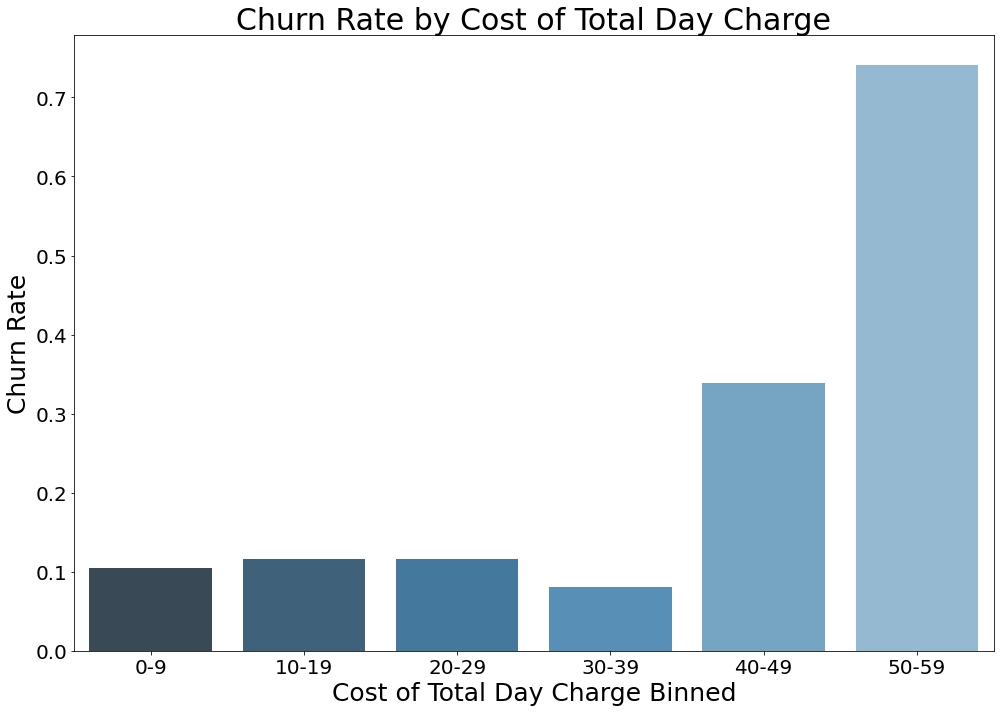

In [142]:
fig, ax = plt.subplots(figsize =(14,10))
sns.barplot(x = day_charge.index, y = day_charge.values, ax = ax, palette = "Blues_d")

plt.title('Churn Rate by Cost of Total Day Charge', fontsize = 30)
plt.xlabel('Cost of Total Day Charge Binned', fontsize = 25)
plt.ylabel('Churn Rate', fontsize = 25)
ax.set_xticklabels(['0-9', '10-19', '20-29','30-39', '40-49', '50-59'])

ax.tick_params(labelsize = 20)
plt.tight_layout()
plt.savefig('../report/figures/CostDayCharge.png',dpi=300, bbox_inches='tight') 

# Final model

In [ ]:
grid_forest2 = {
    'max_features': ['sqrt', 'log2', 0.5, .3, None],
    'n_estimators' : [50, 100, 200, 300]
}
gs_for2 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_forest2, cv=3)

In [ ]:
gs_for2.fit(X_resample, y_resample)

In [ ]:
gs_for2.best_params_

In [50]:
forest_final = RandomForestClassifier(n_estimators=300, max_features=.5, random_state=42, min_samples_split = 3)
forest_final.fit(X_resample, y_resample)
y_hat_forest3 = forest_final.predict(X_test_ss)


In [ ]:
{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 300}

In [408]:
print(cross_val_score(estimator=RandomForestClassifier(n_estimators=300, min_samples_split = 3, max_features=.5, random_state=42), X= X_resample, y = y_resample, cv = 3).mean())
print(forest_final.score(X_test_ss, y_test))
print(confusion_matrix(y_test, y_hat_forest3))
print(classification_report(y_test, y_hat_forest3))

0.9451219871270161
0.9460431654676259
[[688  21]
 [ 24 101]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       709
        True       0.83      0.81      0.82       125

    accuracy                           0.95       834
   macro avg       0.90      0.89      0.89       834
weighted avg       0.95      0.95      0.95       834



# Pipeline